## 🩺 Classificação de Câncer de Pele utilizando CNN
Este notebook realiza o treinamento, avaliação e visualização com Grad-CAM de um modelo baseado em **MobileNetV2** para classificação de imagens dermatológicas.

Todas as seções estão nomeadas em português para facilitar a compreensão do fluxo de trabalho.

### 📦 Importação das Bibliotecas

In [57]:
# Instalar dependências (execute apenas se necessário)
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow shap opencv-python pillow tqdm nbformat

Defaulting to user installation because normal site-packages is not writeable


In [58]:
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2

# Garantir comportamento determinístico
np.random.seed(42)

print('Imports carregados')

Imports carregados


### 📂 Carregamento e Preparação dos Dados

In [59]:
# Detectar automaticamente o dataset e realizar download

def find_latest_kagglehub_dataset(base_dir_name='farjanakabirsamanta/skin-cancer-dataset'):
    home = Path.home()
    cache_base = home / '.cache' / 'kagglehub' / 'datasets'
    if cache_base.exists():
        candidates = list(cache_base.glob(f'**/{base_dir_name}'))
        if not candidates:
            candidates = list(cache_base.glob('**/skin-cancer-dataset'))
        if candidates:
            # ordenar por profundidade e escolher o primeiro mais provável
            candidates.sort(key=lambda p: (str(p).count(os.sep), p.name), reverse=True)
            return Path(candidates[0])
    # fallback: procurar no diretório atual
    cwd = Path.cwd()
    csvs = list(cwd.glob('**/HAM10000_metadata.csv'))
    if csvs:
        return csvs[0].parent
    raise FileNotFoundError('Dataset HAM10000 não encontrado. Coloque o CSV e imagens na pasta do projeto ou no cache do kagglehub.')

dataset_base = find_latest_kagglehub_dataset()

In [60]:
# Carregar metadados e resolver caminhos das imagens
metadata_path = list(dataset_base.glob('**/HAM10000_metadata.csv'))[0]
metadata = pd.read_csv(metadata_path)

# Mapear diagnósticos
mapping = {
    'akiec': 'Queratose actínica',
    'bcc': 'Carcinoma basocelular',
    'bkl': 'Lesão benigna tipo queratose', # Ou: Queratose seborreica (dependendo do contexto exato do bkl)
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Nevo melanocítico', # Popularmente 'pinta'
    'vasc': 'Lesão vascular'
}
metadata['diagnosis'] = metadata['dx'].map(mapping)

## Renomear Colunas
# Mapeamento do nome da coluna original (inglês/código) para o nome desejado (Pt-Br)
column_rename_map = {
    'lesion_id': 'id_lesao',
    'image_id': 'image_id',
    'dx': 'codigo_diagnostico', # O código de diagnóstico original (ex: nv, mel)
    'dx_type': 'tipo_diagnostico',
    'age': 'idade',
    'sex': 'sexo',
    'localization': 'localizacao',
    'diagnosis': 'diagnostico', # O diagnóstico mapeado por extenso
    'image_path': 'image_path'
}

# Aplicar o renomeio
metadata = metadata.rename(columns=column_rename_map)

# localizar pasta de imagens: procurar pastas com muitas imagens
image_folders = [p for p in dataset_base.glob('**/*') if p.is_dir()]
best = None
best_count = 0
for p in image_folders:
    count = len(list(p.glob('*.jpg')))
    if count > best_count:
        best = p
        best_count = count
if best is None or best_count == 0:
    raise FileNotFoundError('Pasta de imagens não encontrada no dataset base: ' + str(dataset_base))
images_root = best

# construir caminho completo

def resolve_image_path(image_id, images_root):
    for ext in ('.jpg', '.jpeg', '.png'):
        candidate = images_root / f"{image_id}{ext}"
        if candidate.exists():
            return str(candidate)
    # procurar recursivamente
    found = list(images_root.rglob(f"{image_id}.*"))
    return str(found[0]) if found else None

metadata['image_path'] = metadata['image_id'].apply(lambda x: resolve_image_path(x, images_root))
metadata = metadata[metadata['image_path'].notnull()].reset_index(drop=True)

# Mapeamento dos valores de sexo
sexo_mapping = {
    'male': 'masculino',
    'female': 'feminino',
    'unknown': 'desconhecido' # Incluindo o valor 'unknown' (desconhecido) por segurança
}

# Aplicar o mapeamento de tradução à coluna 'sexo'
metadata['sexo'] = metadata['sexo'].replace(sexo_mapping)

print('Registros carregados:', len(metadata))
metadata.head()


Registros carregados: 10015


,id_lesao,image_id,codigo_diagnostico,tipo_diagnostico,idade,sexo,localizacao,diagnostico,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,masculino,scalp,Lesão benigna tipo queratose,C:\Users\flmli\.cache\kagglehub\datasets\farja...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,masculino,scalp,Lesão benigna tipo queratose,C:\Users\flmli\.cache\kagglehub\datasets\farja...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,masculino,scalp,Lesão benigna tipo queratose,C:\Users\flmli\.cache\kagglehub\datasets\farja...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,masculino,scalp,Lesão benigna tipo queratose,C:\Users\flmli\.cache\kagglehub\datasets\farja...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,masculino,ear,Lesão benigna tipo queratose,C:\Users\flmli\.cache\kagglehub\datasets\farja...


### 🔍 Exploração de Dados

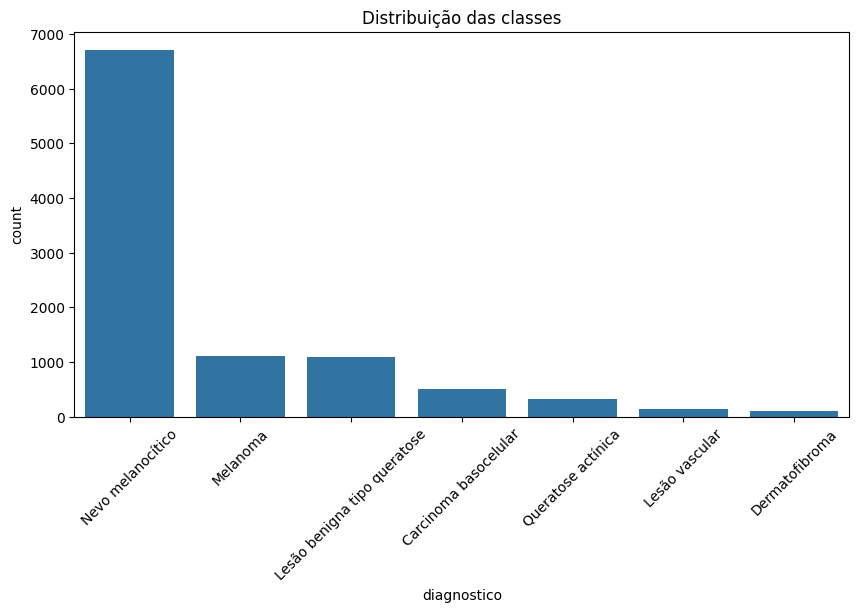

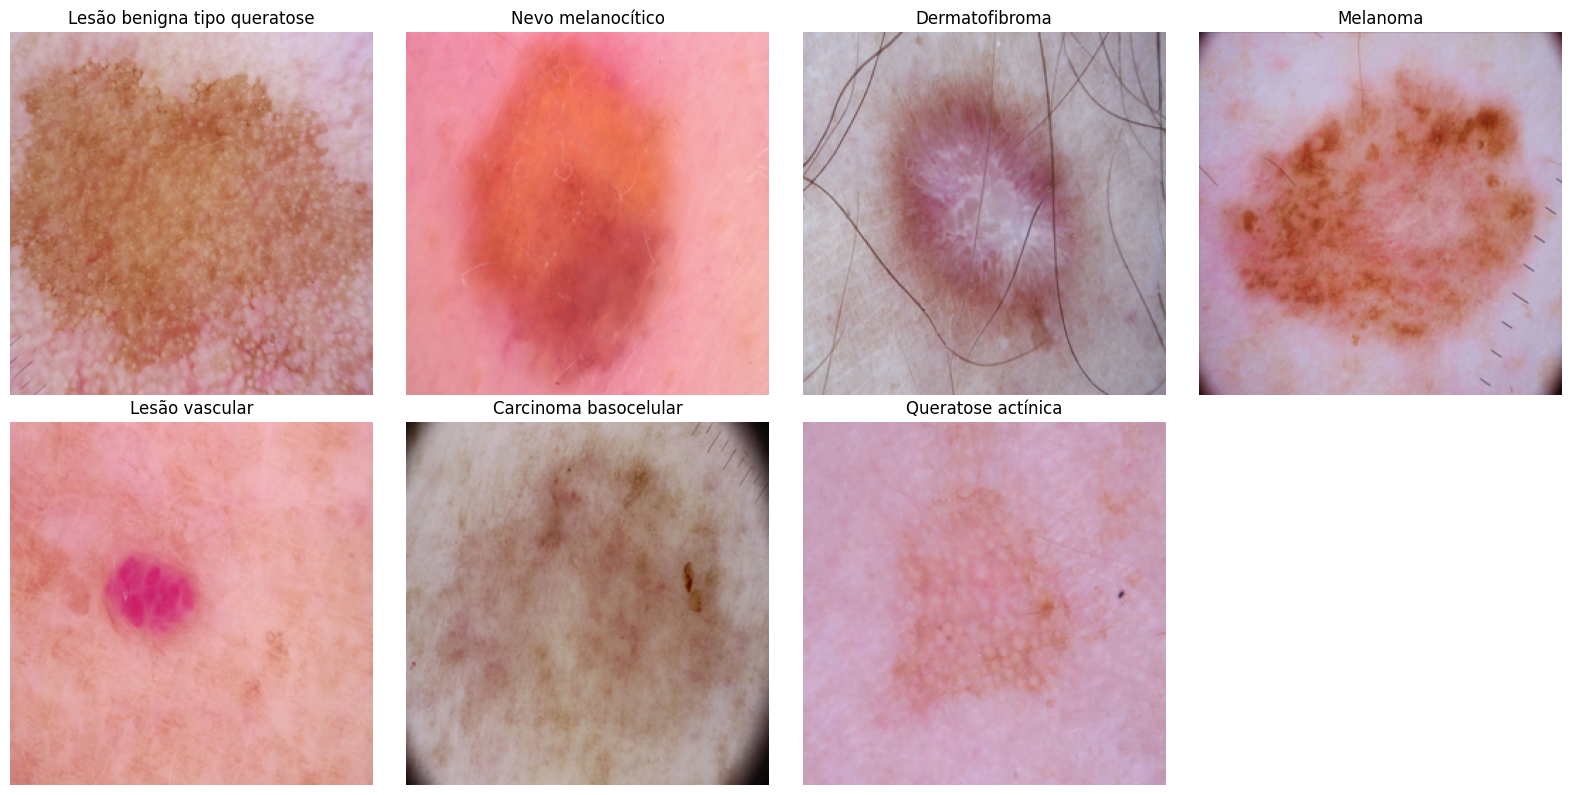

In [61]:

plt.figure(figsize=(10,5))
sns.countplot(data=metadata, x='diagnostico', order=metadata['diagnostico'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição das classes')
plt.show()

unique_labels = metadata['diagnostico'].unique()
cols = 4
rows = (len(unique_labels) + cols - 1) // cols
plt.figure(figsize=(4*cols, 4*rows))
for i, label in enumerate(unique_labels):
    subset = metadata[metadata['diagnostico'] == label]
    if subset.empty:
        continue
    sample_row = subset.sample(1, random_state=42).iloc[0]
    img = Image.open(sample_row['image_path']).convert('RGB')
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.resize((256,256)))
    plt.title(label)
    plt.axis('off')
plt.tight_layout()

### 🧠 Criação e Treinamento do Modelo MobileNetV2

In [62]:
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['diagnostico'])
train_df, temp_df = train_test_split(metadata, stratify=metadata['label'], test_size=0.25, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
test_gen = val_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

Found 7511 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.


In [63]:
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
num_classes = len(train_gen.class_indices)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base.input, outputs=outputs)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
### TREINANDO EPOCHS
EPOCHS = 20
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
217/235 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.4759 - loss: 1.5703

### 📖 Avaliação

C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step
                              precision    recall  f1-score   support

       Carcinoma basocelular       0.03      0.15      0.04        65
              Dermatofibroma       0.00      0.00      0.00        14
Lesão benigna tipo queratose       0.00      0.00      0.00       138
              Lesão vascular       0.00      0.00      0.00        17
                    Melanoma       0.08      0.22      0.12       139
           Nevo melanocítico       0.72      0.07      0.13       838
          Queratose actínica       0.04      0.29      0.07        41

                    accuracy                           0.09      1252
                   macro avg       0.12      0.11      0.05      1252
                weighted avg       0.49      0.09      0.11      1252



C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

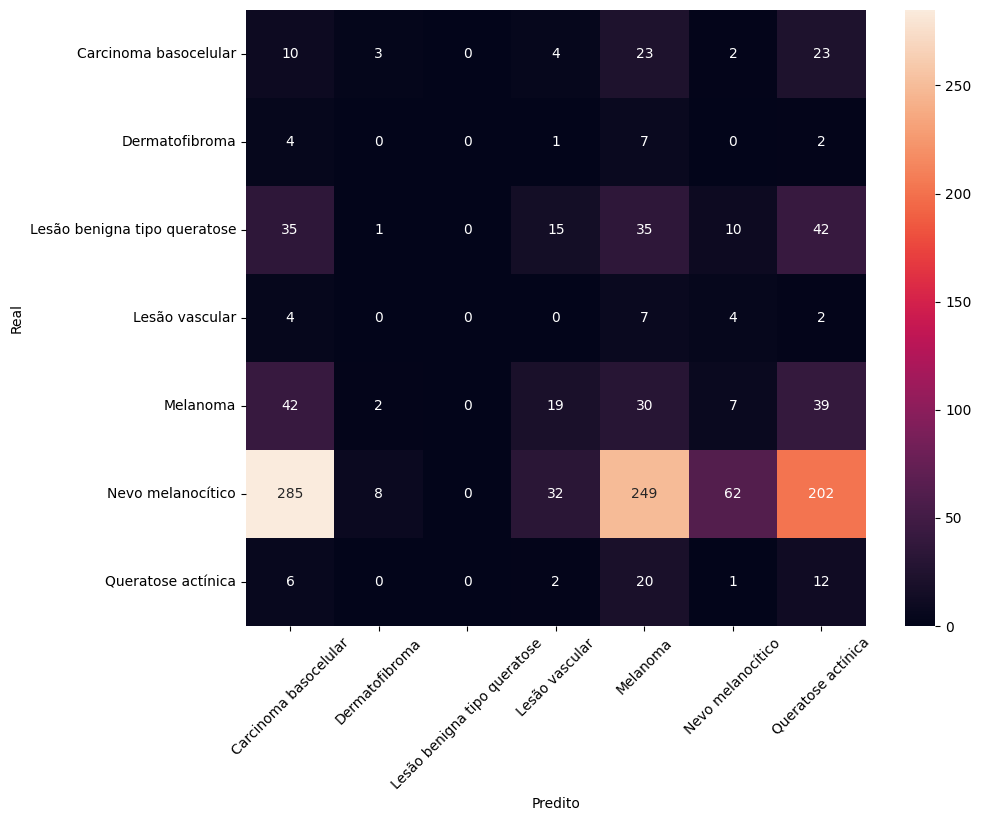

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(train_gen.class_indices.keys()), yticklabels=list(train_gen.class_indices.keys()))
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


### 🔥 Funções Grad-CAM

In [ ]:
# Função para encontrar a última camada convolucional automaticamente
def encontrar_ultima_conv(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError('Nenhuma camada convolucional encontrada.')

ultima_conv = encontrar_ultima_conv(model)

def gerar_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(model.input, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:,:,i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap

def gerar_mapa_gradcam(model, imagem_array, nome_camada_conv):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(nome_camada_conv).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(imagem_array)
        classe_pred = tf.argmax(pred[0])
        loss = pred[:, classe_pred]

    grads = tape.gradient(loss, conv_output)[0]
    pesos = tf.reduce_mean(grads, axis=(0,1))
    gradcam = tf.reduce_sum(tf.multiply(pesos, conv_output[0]), axis=-1)

    heatmap = np.maximum(gradcam, 0) / (tf.reduce_max(gradcam) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap

### 🖼️ Visualização Grad-CAM em Lote

In [ ]:
def gradcam_em_lote(model, df, num_imagens=6):
    exemplos = df.sample(num_imagens, random_state=42).reset_index(drop=True)
    plt.figure(figsize=(8, num_imagens * 3))
    for i, row in exemplos.iterrows():
        imagem = load_img(row['image_path'], target_size=IMG_SIZE)
        imagem_arr = img_to_array(imagem) / 255.0
        entrada = np.expand_dims(imagem_arr, axis=0)
        mapa = gerar_mapa_gradcam(model, entrada, ultima_conv)
        sobreposta = cv2.addWeighted(np.uint8(imagem_arr*255), 0.6, mapa, 0.4, 0)

        plt.subplot(num_imagens, 2, 2*i+1)
        plt.imshow(imagem)
        plt.title(f'Imagem Original: {row["diagnostico"]}')
        plt.axis('off')
        
        plt.subplot(num_imagens, 2, 2*i+2)
        plt.imshow(sobreposta)
        plt.title('Mapa Grad-CAM')
        plt.axis('off')
    plt.tight_layout()

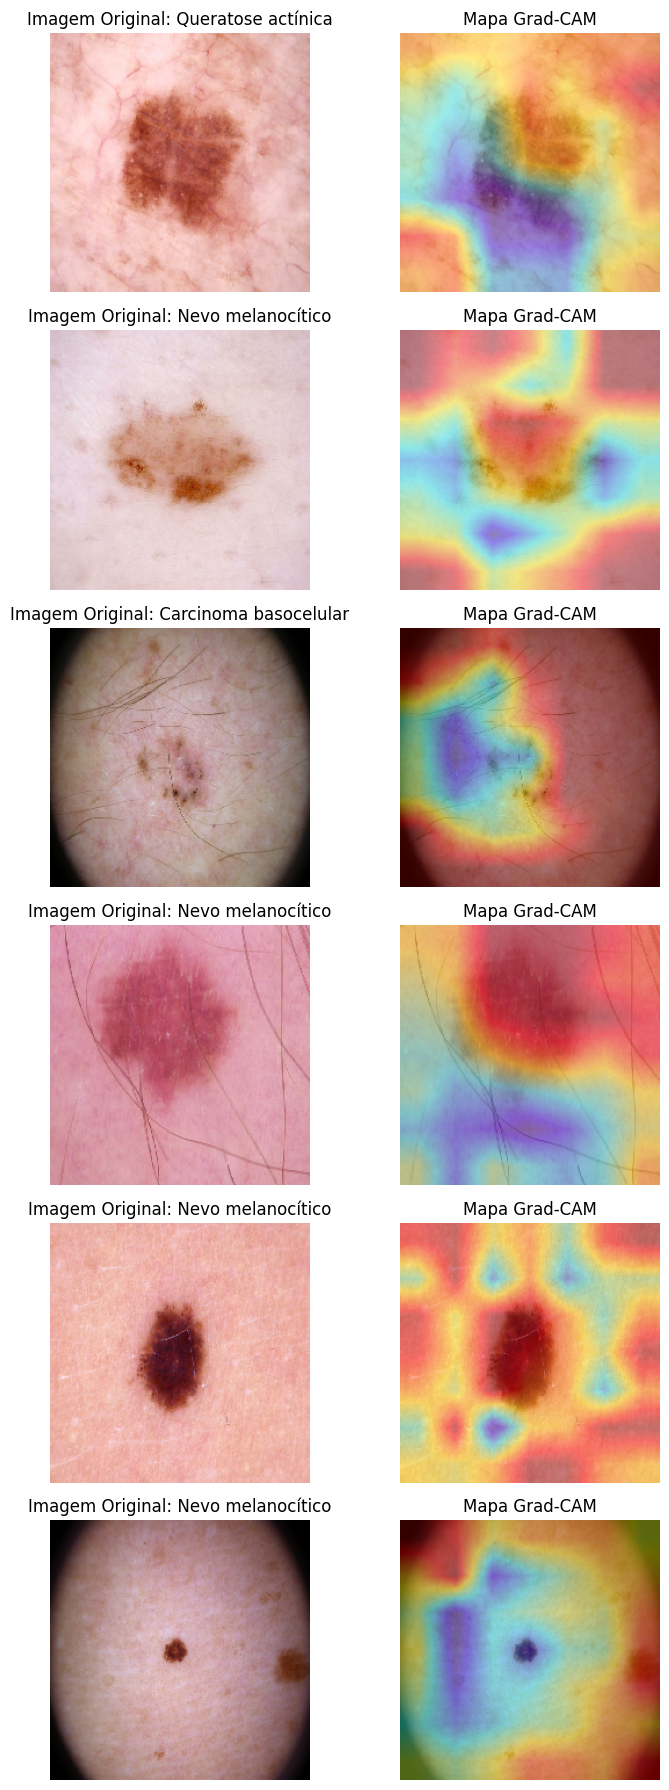

In [ ]:
gradcam_em_lote(model, test_df, num_imagens=6)

### 💾 Salvamento do Modelo (formato moderno .keras)

In [ ]:
model.save('modelo_cancer_pele.keras')
print('Modelo salvo com sucesso!')

Modelo salvo com sucesso!
